In [26]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

SUBSET_LEN = 11
SHIFT_RECORDS = 16 # 0 или конец выборки + 6
storm_wind_speed = 10 # [10 / 1.5, 10, 10 * 1.5]
DPI = 80
FIGSIZE, FIGSIZE_LONG = (10, 6), (12, 6)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('axes', labelsize=20)

In [27]:
wind_df = pd.read_csv("wind.csv", index_col=0)
sea_df = pd.read_csv("sla.csv", index_col=0)

In [28]:
coordinates = wind_df.index
dates = wind_df.columns

Для трех значений параметра $v_{min}$ — минимальной скорости штормового ветра — рассмотрим разницу между средними значениями аномалий уровня моря и скорости ветра в заданных точках.

In [29]:
storms = []
storms_file = open("storms_{}.txt".format(storm_wind_speed), "w")
for i in range(len(coordinates)):
    index = coordinates[i]
    
    j = 0
    while j + SUBSET_LEN < len(dates):
        if wind_df.iloc[i, j] < storm_wind_speed: # нет шторма
            j += 1
        else: # шторм, смотрим
            count_storm, count_calm = 0, 0
            for shift in range(SUBSET_LEN):
                if not np.isnan(sea_df.iloc[i, j + shift]):
                    count_storm += (wind_df.iloc[i, j + shift] >= storm_wind_speed)
                    count_calm += (wind_df.iloc[i, j + shift] < storm_wind_speed)
            
            if count_storm >= 4 and count_calm >= 4 and count_storm + count_calm == SUBSET_LEN:
                cur_row = [count_storm, count_calm, i, j]
                print(" ".join(map(str, cur_row)), file=storms_file)
                storms.append([count_storm, count_calm, i, j]) # начало шторма
            j += SUBSET_LEN
storms_file.close()
print(len(storms))

458652


In [30]:
N_subsets = len(storms)
source_rows_list = []
for index in range(N_subsets):
    i, j = storms[index][2], storms[index][3]
    count_storm = storms[index][0] # количество штормовых дней
    count_calm = storms[index][1] # количество спокойных дней
    storm_coordinates = wind_df.index[i] # координаты шторма
    storm_date = wind_df.columns[j] # дата начала шторма
    
    storm_sea, calm_sea = [], []
    for shift in range(SUBSET_LEN):
        cur_sla = sea_df.iloc[i, j + shift]
        cur_wind = wind_df.iloc[i, j + shift]
        if cur_wind >= storm_wind_speed:
            storm_sea.append(cur_sla)
        else:
            calm_sea.append(cur_sla)
    
    mean_storm_sla = np.mean(storm_sea)
    mean_calm_sla = np.mean(calm_sea)
    row_df = [storm_date, storm_coordinates, count_storm, count_calm, 
              mean_storm_sla, mean_calm_sla, mean_storm_sla - mean_calm_sla]
    source_rows_list.append(row_df)

source_subsets_df = pd.DataFrame(source_rows_list, 
        columns=["start_date", "coordinates", "count_storm", "count_calm", "sla_storm", "sla_calm", "sla_diff"])
sla_diff = source_subsets_df.sla_diff.to_numpy()

In [31]:
csv_filename = "source_subsets_{}.csv".format(storm_wind_speed)
source_subsets_df.to_csv(csv_filename)

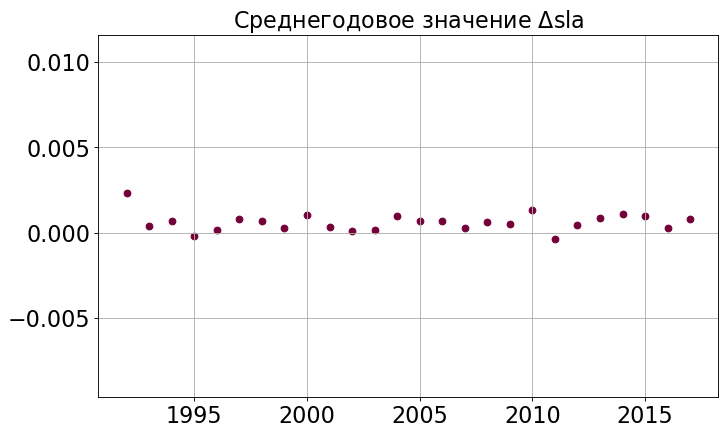

средняя разница: 0.0006186620253916648


In [32]:
source_years = source_subsets_df.apply(lambda x: int(x.start_date[:4]), axis=1)

year_sla_diff = []
start_year = 1992
finish_year = 2018
for cur_year in range(start_year, finish_year):
    cur_year_df = source_subsets_df[source_years == cur_year]
    mean_sla_calm = cur_year_df.sla_calm.mean()
    mean_sla_storm = cur_year_df.sla_storm.mean()
    year_sla_diff.append(mean_sla_storm - mean_sla_calm)

fig = plt.figure(dpi=DPI, figsize=FIGSIZE)
plt.scatter(np.arange(start_year, finish_year), year_sla_diff, color="xkcd:merlot")
plt.title("Среднегодовое значение $\Delta$sla", fontsize=20)
plt.grid(True)
plt.show()

print("средняя разница:", np.array(year_sla_diff).mean())

0.8886879635714285


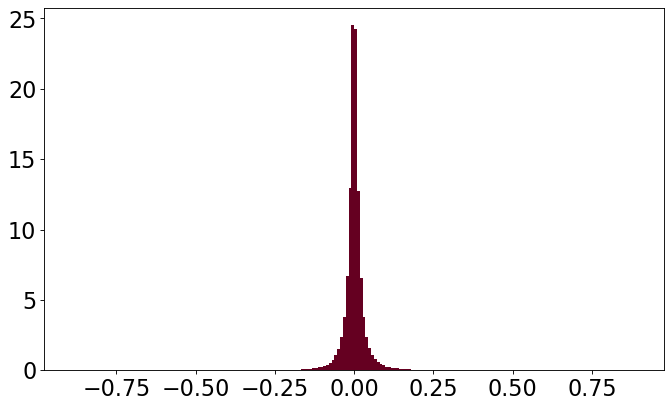

In [33]:
fig = plt.figure(dpi=DPI, figsize=FIGSIZE)
abs_max = abs(sla_diff).max()
print(abs_max)
n_bins = 200
(y, bins, _) = plt.hist(sla_diff, bins=n_bins, density=True, range=(-abs_max, abs_max), color="xkcd:maroon")
x = np.array([(bins[i + 1] + bins[i]) / 2 for i in range(len(bins) - 1)])

Распределение полученной величины ($\Delta sla$) вблизи нуля выглядит следующим образом:

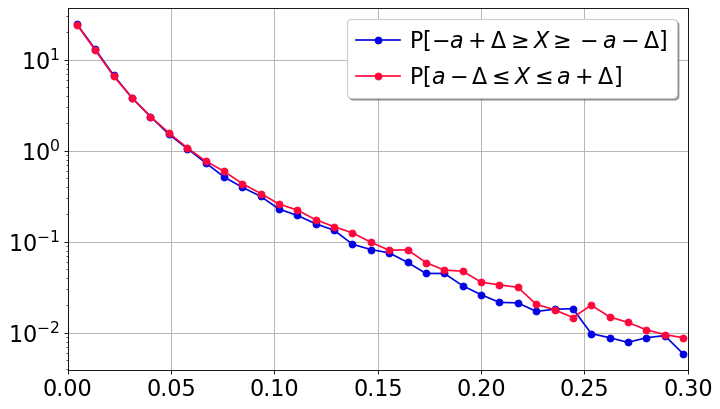

In [34]:
fig = plt.figure(dpi=DPI, figsize=FIGSIZE)
plt.grid(True)
plt.yscale("log")
plt.plot(-x[(x <= 0) & (x >= -0.3)], y[(x <= 0) & (x >= -0.3)], "-o", 
         color="xkcd:pure blue", label="P[$-a + \Delta \geq X \geq -a - \Delta$]")
plt.plot(x[(x >= 0) & (x <= 0.3)], y[(x >= 0) & (x <= 0.3)], "-o", 
         color="xkcd:neon red", label="P[$a - \Delta \leq X \leq a + \Delta$]")
plt.xlim((0.0, 0.3))
plt.legend(handletextpad=0.4, shadow=0.1)
plt.show()
#fig.savefig("new pictures/sla_log_hist_{}.png".format(storm_wind_speed))

In [35]:
random_sla_error_filename = "random_sla_error_{}.txt".format(storm_wind_speed)
random_sla_error = np.loadtxt(random_sla_error_filename, dtype=float)

In [39]:
mean_columns_error = random_sla_error.mean(axis=0)

S = []
for i in range(len(random_sla_error)):
    cur_sla_error = random_sla_error[i]
    assert(len(cur_sla_error) == len(mean_columns_error))
    S.append(np.sum((cur_sla_error - mean_columns_error)**2))

S_990 = sorted(S)[990]
s = random_sla_error.std(axis=0)
delta = s / np.sqrt(np.sum(s**2)) * np.sqrt(S_990)
assert(abs(sum(delta**2) - S_990) < 1e-15)

delta_error_filename = "delta_{}.txt".format(storm_wind_speed)
delta_error_file = open(delta_error_filename, "w")
print(" ".join(map(str, delta)), file=delta_error_file)

In [42]:
delta_10 = np.loadtxt("delta_{}.txt".format(10), dtype=float)
delta_6_7 = np.loadtxt("delta_{}.txt".format(6.7), dtype=float)

In [21]:
test_x = x[(x >= 0) & (x <= 0.4)]
test_red = y[(x >= 0) & (x <= 0.4)]
test_x_reverse = np.flip(x[(x < 0) & (x >= -0.4)])
test_blue_reverse = np.flip(y[(x < 0) & (x >= -0.4)])

assert(len(test_x) == len(test_x_reverse))
assert(len(test_x) == len(test_red))
assert(len(test_red) == len(test_blue_reverse))

eps = 1e-15
mean_y = []
mean_x = []
for i in range(2, len(test_x) - 2):
    sla_diff_expectation = 0.0
    sum_density = 0.0
    for j in range(i - 2, i + 3):
        sla_diff_expectation += (test_red[j] - test_blue_reverse[j]) * test_x[j]
        sum_density += test_red[j] + test_blue_reverse[j]
    assert(abs(test_x[i] + test_x_reverse[i]) < eps)
    mean_y.append(sla_diff_expectation / sum_density)
    mean_x.append(test_x[i])

error_file = open("estimate_error_file.txt", "a")
print(storm_wind_speed, " ".join(map(str, mean_x)), " ".join(map(str, mean_y)), file=error_file)
error_file.close()

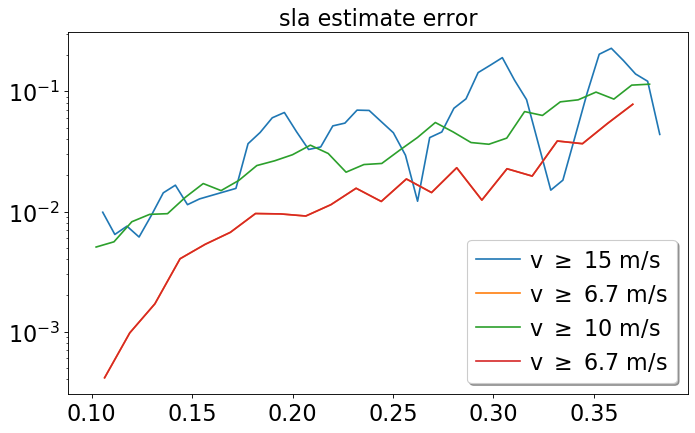

In [41]:
errors_file = open("estimate_error_file.txt", "r")
fig = plt.figure(dpi=DPI, figsize=FIGSIZE)
plt.title("sla estimate error", fontsize=20)

mean_x_10 = []
mean_y_10 = []
mean_x_6_7 = []
mean_y_6_7 = []

for row in errors_file:
    line = list(map(float, row.split()))
    storm_wind = line[0]
    if int(storm_wind) == storm_wind:
        storm_wind = int(storm_wind)
    n = len(line) - 1
    assert(n % 2 == 0)
    mean_x = np.array(line[1:n // 2 + 1])
    mean_y = np.array(line[n // 2 + 1:])
    if storm_wind == 10:
        mean_x_10 = mean_x
        mean_y_10 = mean_y
    elif storm_wind == 6.7:
        mean_x_6_7 = mean_x
        mean_y_6_7 = mean_y
        
    plt.plot(mean_x[(mean_y > 0) & (mean_x >= 0.1)], mean_y[(mean_y > 0) & (mean_x >= 0.1)], 
             label="v $\geq$ {} m/s".format(storm_wind))
    
plt.yscale("log")
#plt.xscale("log")
plt.legend(handletextpad=0.4, shadow=0.1)
plt.show()
fig.savefig("pictures/error_estimate_part_log.png")

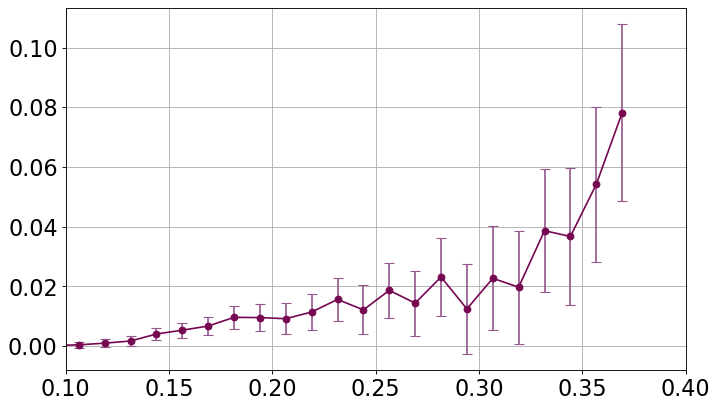

In [23]:
mean_x = np.array(mean_x)
mean_y = np.array(mean_y)

fig = plt.figure(dpi=DPI, figsize=FIGSIZE)
plt.errorbar(mean_x, mean_y, yerr=delta/2, fmt='-o', 
             color="xkcd:velvet", ecolor="xkcd:purplish", capsize=4.5)
plt.xlim((0.1, 0.4))
plt.grid(True)
#plt.yscale("log")
#plt.xscale("log")
plt.show()
fig.savefig("pictures/error_estimate_{}.png".format(storm_wind_speed))

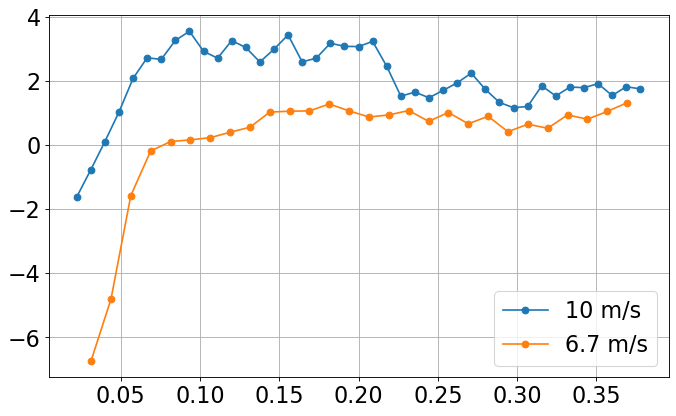

In [45]:
fig = plt.figure(dpi=DPI, figsize=FIGSIZE)
plt.plot(np.array(mean_x_10), np.array(mean_y_10) / np.array(delta_10), "-o", label="10 m/s")
plt.plot(np.array(mean_x_6_7), np.array(mean_y_6_7) / np.array(delta_6_7), "-o", label="6.7 m/s")
plt.legend()
plt.grid(True)
plt.show()
fig.savefig("pictures/error_per_delta_6.7_10.png".format(storm_wind_speed))

k = 2.1136873977793744 b = -0.03206126542891519


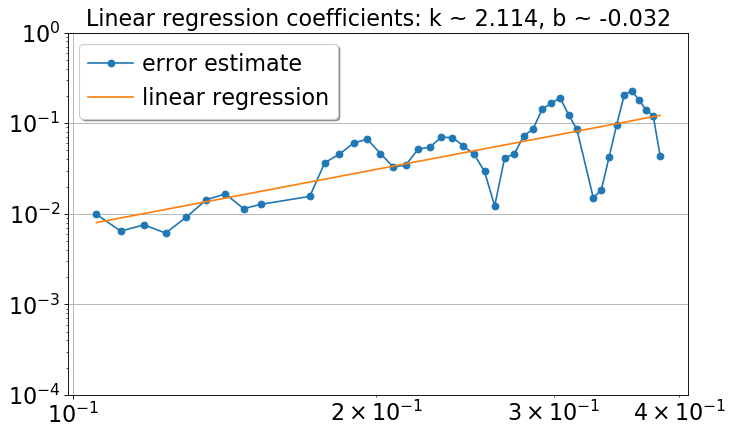

In [131]:
x_reg = np.log10(mean_x[(mean_y > 0) & (np.log10(mean_x) >= -1)]).reshape((-1, 1))
y_reg = np.log10(mean_y[(mean_y > 0) & (np.log10(mean_x) >= -1)])
linear_model = LinearRegression().fit(x_reg, y_reg)
k = linear_model.coef_[0]
b = linear_model.intercept_
print("k =", k, "b =", b)

fig = plt.figure(dpi=DPI, figsize=FIGSIZE)
plt.title("Linear regression coefficients: k ~ {}, b ~ {}".format(round(k, 3), round(b, 3)), fontsize=20)
plt.plot(np.power(10, x_reg), np.power(10, y_reg), "-o", label="error estimate")
plt.plot(np.power(10, x_reg), np.power(10, k * x_reg + b), label="linear regression")
plt.grid(True)
plt.ylim((1e-4, 1e-0))
plt.yscale("log")
plt.xscale("log")
plt.legend(handletextpad=0.4, shadow=0.1)
plt.show()
fig.savefig("pictures/error_estimate_linear_{}.png".format(storm_wind_speed))

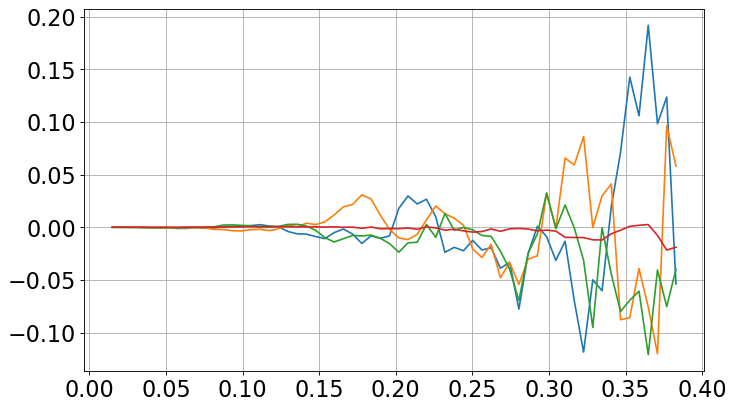

In [132]:
fig = plt.figure(dpi=DPI, figsize=FIGSIZE)
plt.plot(mean_x, random_sla_error[np.random.randint(len(random_sla_error))])
plt.plot(mean_x, random_sla_error[np.random.randint(len(random_sla_error))])
plt.plot(mean_x, random_sla_error[np.random.randint(len(random_sla_error))])
plt.plot(mean_x, mean_columns_error)
plt.grid(True)
plt.show()
fig.savefig("pictures/random_error_estimate_{}.png".format(storm_wind_speed))

k = 2.5761351868179023 b = -0.16931694790751717


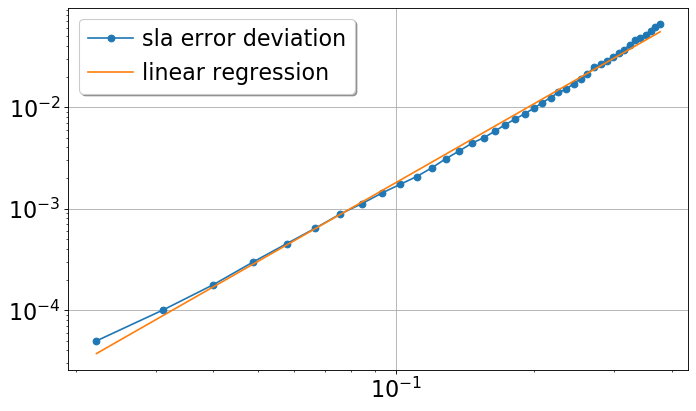

In [172]:
from sklearn.linear_model import LinearRegression
x_reg = np.log10(np.array(mean_x)).reshape((-1, 1))
y_reg = np.log10(np.array(delta))
linear_model = LinearRegression().fit(x_reg, y_reg)
k = linear_model.coef_[0]
b = linear_model.intercept_
print("k =", k, "b =", b)

fig = plt.figure(dpi=DPI, figsize=FIGSIZE)
plt.plot(mean_x, delta, "-o", label="sla error deviation")
plt.plot(mean_x, np.power(10, x_reg * k + b), label="linear regression")
plt.legend(handletextpad=0.4, shadow=0.1)
plt.yscale("log")
#plt.xlim((0.2, 0.4))
plt.xscale("log")
plt.grid(True)
plt.show()
fig.savefig("pictures/delta_std_{}.png".format(storm_wind_speed))

In [41]:
deltas_file = open("delta_std.txt", "a")
print(storm_wind_speed, " ".join(map(str, mean_x)), " ".join(map(str, delta)), file=deltas_file)
deltas_file.close()

k = 2.8083069563015273 b = -0.025088230151991908


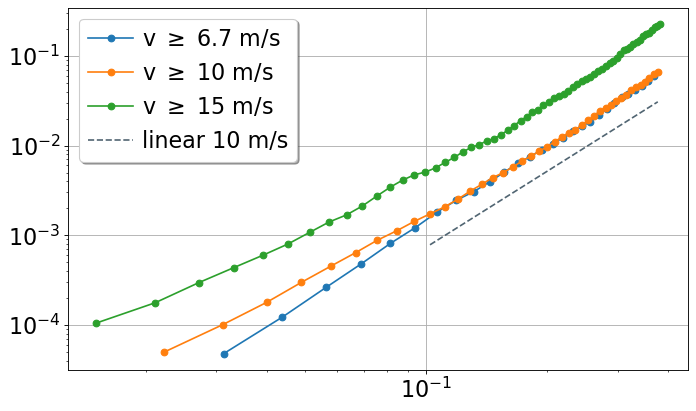

In [181]:
from sklearn.linear_model import LinearRegression
deltas_file = open("delta_std.txt", "r")
#lines = np.loadtxt("delta_std.txt", dtype=float)

fig = plt.figure(dpi=DPI, figsize=FIGSIZE)
plt.grid(True)
for row in deltas_file:
    line = list(map(float, row.split()))
    wind_speed = line[0]
    if int(wind_speed) == wind_speed:
        wind_speed = int(wind_speed)
        
    n = len(line) - 1
    assert(n % 2 == 0)
    delta_x = np.array(line[1:1 + n//2])
    delta_y = np.array(line[1 + n//2:])
    assert(len(delta_x) == len(delta_y))
    plt.plot(delta_x, delta_y, "-o", label="v $\geq$ {} m/s".format(wind_speed))
    
    if wind_speed == 10:
        x_reg = np.log10(np.array(delta_x[delta_x >= 0.1])).reshape((-1, 1))
        y_reg = np.log10(np.array(delta_y[delta_x >= 0.1]))
        linear_model = LinearRegression().fit(x_reg, y_reg)
        k = linear_model.coef_[0]
        b = linear_model.intercept_
        print("k =", k, "b =", b)
        plt.plot(np.power(10, x_reg), np.power(10, k * x_reg + b - 0.3), 
                 "--", color="xkcd:slate", label="linear 10 m/s")

handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 1, 3, 2]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
           handletextpad=0.4, shadow=0.1)
plt.yscale("log")
plt.xscale("log")
plt.show()
fig.savefig("pictures/deltas_std.png")

In [182]:
a = [(1, 2), (3, 4)]
dict(a)

{1: 2, 3: 4}

Площадь под красным графиков больше соответствующей площади под синим графиком, следовательно, положительные значения $\Delta sla$ встречаются немного чаще симметричных отрицательных.

Для того, чтобы оценить статистическую значимость найденного эффекта, сгенерируем набор сдвинутых во времени выборок, после чего 1000 раз найдем аналогичную разницу в рандомизированном разбиении сдвинутых выборок на штормовые и спокойные дни.

In [20]:
tests_number = 1000

In [21]:
x_min = dict({6.7: 0.05, 10: 0.015, 15: 0.0}) # [start_a, 0.5] с шагом 0.005
a = np.arange(x_min[storm_wind_speed], 0.5001, 0.005)
y_min = dict({6.7: 1e-5, 10: 1e-5, 15: 1e-4})
y_max = dict({6.7: 1e-3, 10: 1e-2, 15: 10**(-1.5)})
x_max = dict({6.7: 0.42, 10: 0.5, 15: 0.5})

def getProbabilityDifference(values, a_array): # P[X >= a] - P[X <= -a]
    return np.array([((values >= a).sum() - (values <= -a).sum()) / values.size for a in a_array])

In [22]:
random_expectations_filename = "random_exp_{}_{}.txt".format(storm_wind_speed, SHIFT_RECORDS)
random_expectations = np.loadtxt(random_expectations_filename, dtype=float)
assert(random_expectations.shape == (tests_number,))

In [23]:
random_proba_filename = "random_proba_{}_{}.txt".format(storm_wind_speed, SHIFT_RECORDS)
random_proba_difference = np.loadtxt(random_proba_filename, dtype=float)
assert(random_proba_difference.shape == (tests_number, len(a)))

In [24]:
need_percentile = 99
need_index = 990
random_proba_endvalues = [np.percentile(random_proba_difference[:,i], need_percentile) for i in range(len(a))]
real_proba_difference = getProbabilityDifference(sla_diff, a)
test_number = np.where(random_expectations == sorted(random_expectations)[need_index])[0][0]

In [25]:
picture_file = open("graph_{}_{}.txt".format(storm_wind_speed, SHIFT_RECORDS), "w")
print(" ".join(map(str, real_proba_difference)), file=picture_file)
print(" ".join(map(str, random_proba_endvalues)), file=picture_file)
print(" ".join(map(str, random_proba_difference[test_number])), file=picture_file)
picture_file.close()

speed = 6.7 shift = 16


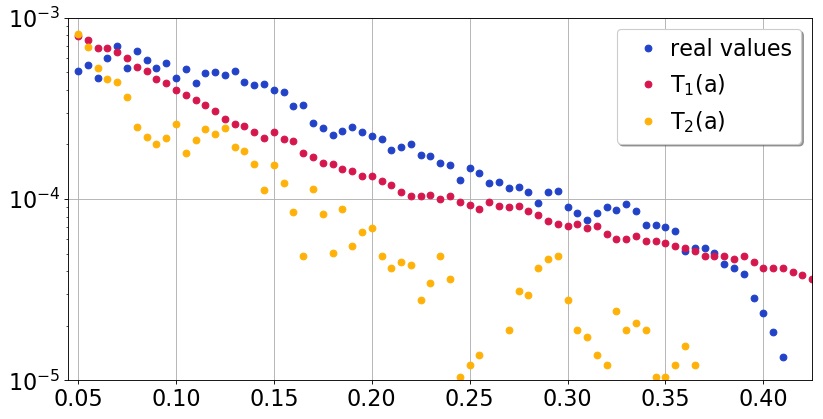

In [27]:
for storm_wind_speed in [6.7]:
    for shift in [16]:
        print("speed =", storm_wind_speed, "shift =", shift)
        a = np.arange(x_min[storm_wind_speed], 0.5001, 0.005)

        picture_file = open("graph_{}_{}.txt".format(storm_wind_speed, shift), "r")
        first_line = list(map(float, picture_file.readline().split()))
        assert(len(first_line) == len(a))
        second_line = list(map(float, picture_file.readline().split()))
        assert(len(second_line) == len(a))
        third_line = list(map(float, picture_file.readline().split()))
        assert(len(third_line) == len(a))
        picture_file.close()

        fig = plt.figure(dpi=DPI, figsize=FIGSIZE_LONG)
        plt.plot(a, first_line, "o", color="xkcd:blue blue", label="real values")
        plt.plot(a, second_line, "o", color="xkcd:lipstick", label="T$_1$(a)")
        plt.plot(a, third_line, "o", color="xkcd:saffron", label="T$_2$(a)")
        plt.ylim(y_min[storm_wind_speed], y_max[storm_wind_speed])
        plt.xlim(x_min[storm_wind_speed] - 0.005, x_max[storm_wind_speed] + 0.005)
        plt.grid(True)
        plt.yscale("log")
        plt.legend(handletextpad=0.0, shadow=0.1)
        plt.show()
        fig.savefig("random_tests_log_{}_{}.pdf".format(storm_wind_speed, shift))

Таким образом, реальные наблюдаемые значения оказываются заметно больше даже крайних значений, полученных в результате статистического тестирования. Следовательно, можно говорить о статистической значимости найденного эффекта.